In [1]:
import numpy as np
import instrument as ins
import isochrones as iso
import galaxy as gal
import driver
import matplotlib.pyplot as plt
import matplotlib as mpl
import fit_model

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
/n/home01/bcook/.conda/envs/my_home/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


GPU acceleration enabled


In [2]:
import time

In [3]:
import utils
import gpu_utils
# from scipy.stats import poisson
import time
import emcee
# import corner

In [4]:
%matplotlib inline

In [5]:
import seaborn.apionly as sns

ImportError: No module named seaborn.apionly

In [6]:
sns.set_context('poster')
sns.set_style('ticks')

NameError: name 'sns' is not defined

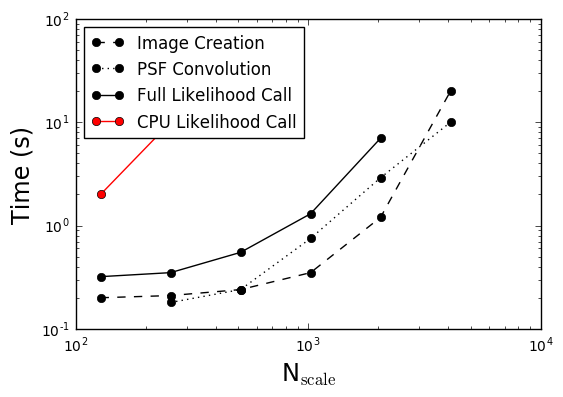

In [7]:
N_arr = np.array([128, 256, 512, 1024, 2048, 4096])
fig, axis = plt.subplots()
t_im = np.array([0.2, 0.21, 0.24, 0.35, 1.2, 20.])
axis.plot(N_arr, t_im, 'ko--', label='Image Creation')
t_psf = np.array([0.18, 0.24, 0.75, 2.9, 10.])
axis.plot(N_arr[1:], t_psf, 'ko:', label='PSF Convolution')
t_like = np.array([0.32, 0.35, 0.55, 1.3, 7.])
axis.plot(N_arr[:-1], t_like, 'ko-', label='Full Likelihood Call')
axis.plot([128, 256, 512], [2., 10., 70.], 'ro-', label='CPU Likelihood Call')
axis.legend(loc=2), axis.set_xlabel(r'N$_\mathrm{scale}$', fontsize='xx-large')
axis.set_ylabel('Time (s)', fontsize='xx-large')
axis.set_xscale('log'), axis.set_yscale('log');

In [8]:
reload(gpu_utils)

GPU acceleration enabled


<module 'gpu_utils' from 'gpu_utils.pyc'>

In [9]:
reload(driver)

<module 'driver' from 'driver.pyc'>

In [10]:
def plot_pixcmd(mags, ax=None, colorbar=True):
    pcmd = utils.make_pcmd(mags)
    if ax is None:
        fig, ax = plt.subplots()
    plt.subplot(ax)
    plt.hist2d(pcmd[0], pcmd[1], bins=150, cmap='viridis', norm=mpl.colors.LogNorm())
    if colorbar:
        plt.colorbar(label='Pixel Counts')
    return ax

In [11]:
im_scale = 256
filters = [ins.Filter.HST_F475W(1.), ins.Filter.HST_F814W(1.)]
n_filters = len(filters)

In [12]:
iso_model = iso.Isochrone_Model(filters)
# gal_model_complex = gal.Galaxy_Model(1e2, np.array([6.5, 7.5, 8.25, 8.75, 9.25, 9.75, 10.1]), np.array([0.,1.,1.,1.,1.,1.,1.]), 0., 0.)
gal_model_simple = gal.Galaxy_SSP(np.array([-0.2, -2., 2., 9.6]))
gal_model_almost = gal.Galaxy_SSP(np.array([-0.15, -2.05, 2.1, 9.7]))

gal_model_dust = gal.Galaxy_SSP(np.array([-0.2, -0.5, 2., 9.6]))
gal_model_bad = gal.Galaxy_SSP(np.array([-1.9, -5.9, -0.9, 6.1]))
gal_model_lessbad = gal.Galaxy_SSP(np.array([-1.0, -4.0, 1.3, 7.4]))
gal_model_full = gal.Galaxy_Model(np.array([0., -2., 1., 1., 1., 1., 1., 1., 1.]))

In [13]:
driver_cpu = driver.Driver(iso_model, gpu=False)
driver_gpu = driver.Driver(iso_model, gpu=True)

In [14]:
%%time
_, mags_single, _, _ = driver_cpu.simulate(gal_model_simple, im_scale, psf=True, multi_psf=True, fixed_seed=True)

CPU times: user 1.37 s, sys: 98 ms, total: 1.46 s
Wall time: 1.47 s


In [31]:
%%time
_, mags_single_2, _, _ = driver_cpu.simulate(gal_model_simple, im_scale, psf=True, multi_psf=True, fixed_seed=True)

CPU times: user 755 ms, sys: 96.7 ms, total: 852 ms
Wall time: 853 ms


In [32]:
%%time
_, mags_dust, _, _ = driver_cpu.simulate(gal_model_dust, im_scale, psf=True, multi_psf=True, fixed_seed=True)

CPU times: user 740 ms, sys: 95.1 ms, total: 835 ms
Wall time: 835 ms


In [33]:
%%time
_, mags_bad, _, _ = driver_cpu.simulate(gal_model_bad, im_scale, psf=True, multi_psf=True, fixed_seed=True)

CPU times: user 307 ms, sys: 50.2 ms, total: 357 ms
Wall time: 358 ms


In [34]:
%%time
_, mags_lessbad, _, _ = driver_cpu.simulate(gal_model_lessbad, im_scale, psf=True, multi_psf=True, fixed_seed=True)

CPU times: user 656 ms, sys: 97 ms, total: 753 ms
Wall time: 756 ms


In [15]:
xbins = np.arange(-1.5, 4.6, 0.05)
ybins = np.arange(-12, 15.6, 0.05)
bins = np.array([xbins, ybins])   

In [16]:
pcmd = utils.make_pcmd(mags_single)
driver_cpu.initialize_data(pcmd, bins)

In [26]:
%%time
_, mags_single_c, _, _ = driver_cpu.simulate(gal_model_simple, im_scale, psf=True, multi_psf=True, fixed_seed=True)

CPU times: user 1.33 s, sys: 107 ms, total: 1.44 s
Wall time: 1.44 s


In [27]:
%%time
_, mags_single_g, _, _ = driver_gpu.simulate(gal_model_simple, im_scale, psf=True, multi_psf=True, fixed_seed=True)

CPU times: user 205 ms, sys: 39 ms, total: 244 ms
Wall time: 381 ms


In [22]:
%%time
_, mags_single_2, _, _ = driver_gpu.simulate(gal_model_simple, im_scale, psf=True, multi_psf=True, fixed_seed=True)

CPU times: user 215 ms, sys: 28 ms, total: 243 ms
Wall time: 375 ms


In [34]:
pcmd = utils.make_pcmd(mags_single_g)
driver_cpu.initialize_data(pcmd, bins)
driver_gpu.initialize_data(pcmd, bins)

In [39]:
driver_cpu.loglike(utils.make_pcmd(mags_single_2))

-854.72496524073199

In [40]:
driver_gpu.loglike(utils.make_pcmd(mags_single_2))

-854.72496524073199

In [23]:
pcmd = utils.make_pcmd(mags_single)
driver_gpu.initialize_data(pcmd, bins)

In [24]:
driver_gpu.loglike(utils.make_pcmd(mags_single))

-0.0

In [25]:
driver_gpu.loglike(utils.make_pcmd(mags_single_2))

-861.35741719424971

In [19]:
fit_model.lnprob(gal_model_simple._params, driver_gpu, im_scale, gal_class=gal.Galaxy_SSP, fixed_seed=True)

-925.37585606256141

In [44]:
fit_model.lnprob(gal_model_almost._params, driver_cpu, im_scale, gal_class=gal.Galaxy_SSP, fixed_seed=True)

-19436.9067805


-19436.906780455836

In [40]:
fit_model.lnprob(gal_model_dust._params, driver_cpu, im_scale, gal_class=gal.Galaxy_SSP, fixed_seed=True)

-123183.959896


-123183.95989579475

In [41]:
fit_model.lnprob(gal_model_bad._params, driver_cpu, im_scale, gal_class=gal.Galaxy_SSP, fixed_seed=True)

-111835.040057


-111835.04005699839

In [42]:
fit_model.lnprob(gal_model_lessbad._params, driver_cpu, im_scale, gal_class=gal.Galaxy_SSP, fixed_seed=True)

-119958.835005


-119958.83500487545

In [34]:
correct = gal_model_simple._params
log_z = correct[0] + [-0.5, -0.05, 0.,0.05, 0.5]
log_dust = correct[1] + [0.]# + [-0.5,  -0.05, 0., 0.05, 0.5]
log_npix = correct[2] + [-0.5, -0.05, 0., 0.05, 0.5]
log_age = correct[3] + [ -1.5, -0.5, -0.1, 0., 0.1, 0.5]

In [39]:
len(log_age)

6

In [40]:
im_scale = 128
lnprobs = np.zeros((len(log_z), len(log_dust), len(log_npix), len(log_age)))
n = 0
#for j in range(len(log_dust)):
j = 0
for i in range(len(log_z)):
    for k in range(len(log_npix)):
        for m in range(len(log_age)):
            model = np.array([log_z[i], log_dust[j], log_npix[k], log_age[m]])
            lnprobs[i,j,k,m] = fit_model.lnprob(model, driver_cpu, im_scale, gal_class=gal.Galaxy_SSP, 
                                                fixed_seed=True)
            n += 1
            print('%d of %d'%(n, lnprobs.size))

1 of 150
2 of 150
3 of 150
4 of 150
5 of 150
6 of 150
7 of 150
8 of 150
9 of 150
10 of 150
11 of 150
12 of 150
13 of 150
14 of 150
15 of 150
16 of 150
17 of 150
18 of 150
19 of 150
20 of 150
21 of 150
22 of 150
23 of 150
24 of 150
25 of 150
26 of 150
27 of 150
28 of 150
29 of 150
30 of 150
31 of 150
32 of 150
33 of 150
34 of 150
35 of 150
36 of 150
37 of 150
38 of 150
39 of 150
40 of 150
41 of 150
42 of 150
43 of 150
44 of 150
45 of 150
46 of 150
47 of 150
48 of 150
49 of 150
50 of 150
51 of 150
52 of 150
53 of 150
54 of 150
55 of 150
56 of 150
57 of 150
58 of 150
59 of 150
60 of 150
61 of 150
62 of 150
63 of 150
64 of 150
65 of 150
66 of 150
67 of 150
68 of 150
69 of 150
70 of 150
71 of 150
72 of 150
73 of 150
74 of 150
75 of 150
76 of 150
77 of 150
78 of 150
79 of 150
80 of 150
81 of 150
82 of 150
83 of 150
84 of 150
85 of 150
86 of 150
87 of 150
88 of 150
89 of 150
90 of 150
91 of 150
92 of 150
93 of 150
94 of 150
95 of 150
96 of 150
97 of 150
98 of 150
99 of 150
100 of 150
101 of 1

In [32]:
lnprobs.size

150

In [28]:
lnprobs

array([[[[-38757.53854595],
         [-21462.64075312],
         [-25228.40578514],
         [-36093.45078199],
         [-63229.97385258]]],


       [[[-52031.33360598],
         [ -1553.66870286],
         [ -1333.96405255],
         [ -7592.25052003],
         [-63046.32624826]]],


       [[[-54820.01645434],
         [ -3423.20930824],
         [  -851.25355993],
         [ -4209.1533397 ],
         [-62513.96190265]]],


       [[[-57068.39388928],
         [ -8878.00121886],
         [ -3387.92947846],
         [ -3409.91226072],
         [-62213.57847002]]],


       [[[-62410.2066653 ],
         [-50620.24033992],
         [-46347.9253156 ],
         [-42977.10907889],
         [-55554.08475516]]]])

In [18]:
%%time
_, mags_other, _, _ = driver_cpu.simulate(gal_model_simple, im_scale, psf=True, multi_psf=True)

CPU times: user 774 ms, sys: 121 ms, total: 895 ms
Wall time: 1.07 s


In [51]:
%%time
_, mags_multi, _, _ = driver_cpu.simulate(gal_model_simple, im_scale, psf=True, multi_psf=True)

CPU times: user 9.62 s, sys: 1.08 s, total: 10.7 s
Wall time: 10.8 s


In [57]:
pcmd = utils.make_pcmd(mags_multi)

In [64]:
pcmd_other = utils.make_pcmd(mags_other)

In [61]:
pcmd_1 = utils.make_pcmd(mags_single)

In [58]:
xbins, ybins = np.arange(-1.5, 4.6, 0.05), np.arange(-12, 15.6, 0.05)
bins = np.array([xbins, ybins])

In [59]:
driver_cpu.initialize_data(pcmd, bins)

In [65]:
driver_cpu.loglike(pcmd_other)

-3834.5671273538719

In [75]:
gal_model_simple._params

array([  0. ,  -2. ,   0.5,  10. ])

In [74]:
fit_model.lnprob(gal_model_simple._params, driver_cpu, 1024, gal_class=gal.Galaxy_SSP)

-4231.0223883435201

In [78]:
fit_model.lnprob([-2., -6., -1., 6.], driver_cpu, 256, gal_class=gal.Galaxy_SSP)

-138934.79143680469

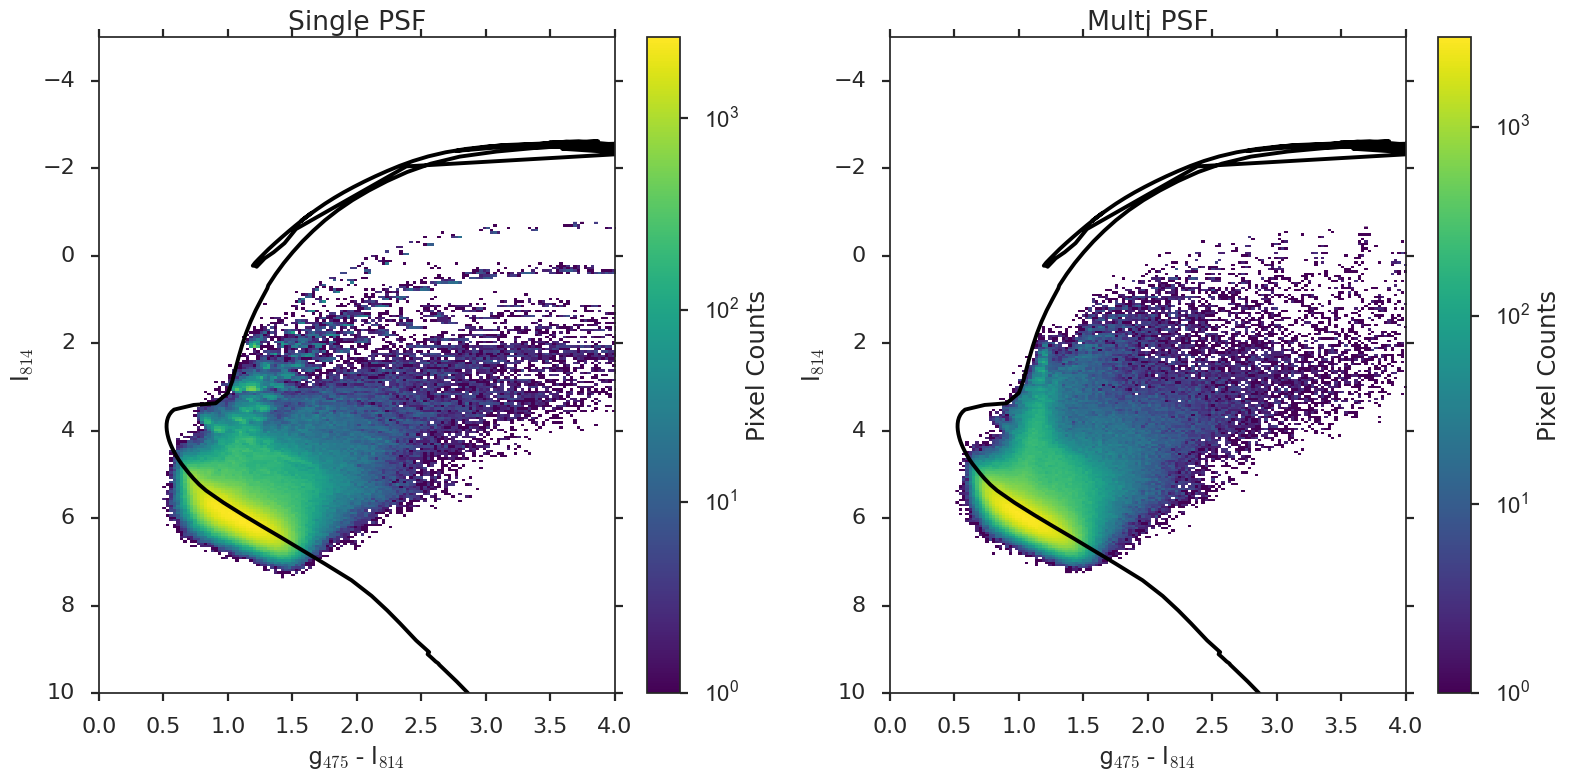

In [52]:
fig, axes = plt.subplots(figsize=(16,8), ncols=2)
plot_pixcmd(mags_single, ax=axes[0], colorbar=True)
plot_pixcmd(mags_multi, ax=axes[1])
iso_model.plot_isochrone(gal_model_simple, ax=axes[0])
iso_model.plot_isochrone(gal_model_simple, ax=axes[1])
axes[0].set_ylim([10, -5])
axes[0].set_xlim([0, 4])
axes[1].set_ylim([10, -5])
axes[1].set_xlim([0, 4])
axes[0].set_title('Single PSF'), axes[1].set_title('Multi PSF')
plt.tight_layout()
# plt.savefig('../../sandbox/2b_PSF.pdf')

In [7]:
%%time
_, mags_sim, _, _ = driver_cpu.simulate(gal_model_simple, 256, psf=True, multi_psf=False)

CPU times: user 632 ms, sys: 104 ms, total: 735 ms
Wall time: 739 ms


In [12]:
%%time
_, mags_dust, _, _ = driver_cpu.simulate(gal_model_dust, 256, psf=True)

CPU times: user 776 ms, sys: 121 ms, total: 897 ms
Wall time: 1.05 s


In [8]:
pcmd = utils.make_pcmd(mags_sim)

In [14]:
pcmd_dust = utils.make_pcmd(mags_dust)

In [9]:
xbins, ybins = np.arange(-1.5, 4.6, 0.05), np.arange(-12, 5.6, 0.05)
bins = np.array([xbins, ybins])

In [10]:
driver_cpu.initialize_data(pcmd, bins)

In [16]:
driver_cpu.loglike(pcmd_dust)

-111180.67674433916

In [8]:
SFH_SSP, mags_SSP = iso_model.model_galaxy(gal_model_simple)
SFH_full, mags_full = iso_model.model_galaxy(gal_model_full)

In [9]:
fluxes_SSP = np.array([f.mag_to_counts(m) for f,m in zip(filters, mags_SSP)])
fluxes_full = np.array([f.mag_to_counts(m) for f,m in zip(filters, mags_full)])

In [10]:
def time_func(func, SFH, fluxes, N_scale_arr):
    time_arr = np.zeros_like(N_scale_arr, dtype=float)
    for i in np.arange(len(N_scale_arr)):
        start = time.time()
        _ = func(SFH, fluxes, N_scale_arr[i])
        time_arr[i] = time.time() - start
    return time_arr

In [28]:
N_scale_arr = np.array([128, 256, 512, 1024, 2048, 4096])

In [29]:
times_cudac_SSP = time_func(gpu_utils._draw_image_cudac, SFH_SSP, fluxes_SSP, N_scale_arr)
# times_pycuda_SSP = time_func(gpu_utils._draw_image_pycuda, SFH_SSP, fluxes_SSP, N_scale_arr)
# times_numpy_SSP = time_func(gpu_utils._draw_image_numpy, SFH_SSP, fluxes_SSP, N_scale_arr[:-1])

In [30]:
times_cudac_full = time_func(gpu_utils._draw_image_cudac, SFH_full, fluxes_full, N_scale_arr)
# times_pycuda_full = time_func(gpu_utils._draw_image_pycuda, SFH_full, fluxes_full, N_scale_arr)
# times_numpy_full = time_func(gpu_utils._draw_image_numpy, SFH_full, fluxes_full, N_scale_arr[:-2])

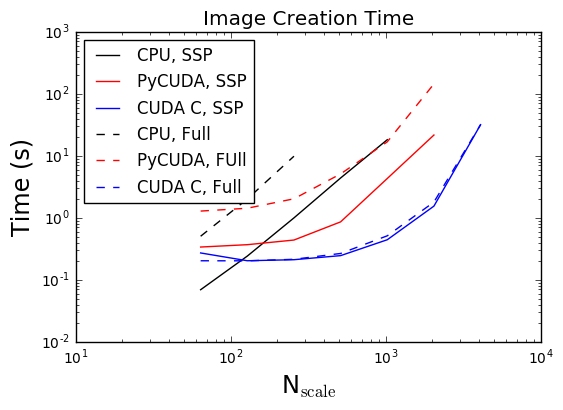

In [34]:
fig, axis =plt.subplots()
axis.plot(N_scale_arr[:-2], times_numpy_SSP, ls='-', color='k', label='CPU, SSP')
axis.plot(N_scale_arr[:-1], times_pycuda_SSP, ls='-', color='r', label='PyCUDA, SSP')
axis.plot(N_scale_arr, times_cudac_SSP, ls='-', color='b', label='CUDA C, SSP')
axis.plot(N_scale_arr[:-4], times_numpy_full, ls='--', color='k', label='CPU, Full')
axis.plot(N_scale_arr[:-1], times_pycuda_full, ls='--', color='r', label='PyCUDA, FUll')
axis.plot(N_scale_arr, times_cudac_full, ls='--', color='b', label='CUDA C, Full')
axis.set_xlabel(r'N$_\mathrm{scale}$', fontsize='xx-large'), axis.set_ylabel('Time (s)', fontsize='xx-large')
axis.legend(loc=2), axis.set_yscale('log'), axis.set_xscale('log')
axis.set_title('Image Creation Time', fontsize='x-large')
plt.savefig('results/image_draw_time.pdf')

In [11]:
%%time
_, mags_sim, _, _ = driver_gpu.simulate(gal_model_simple, 1024, psf=True)

CPU times: user 1.07 s, sys: 294 ms, total: 1.36 s
Wall time: 1.65 s


In [12]:
pcmd = utils.make_pcmd(mags_sim)

In [13]:
xbins, ybins = np.arange(-1.5, 4.6, 0.05), np.arange(-12, 5.6, 0.05)
bins = np.array([xbins, ybins])

In [14]:
driver_cpu.initialize_data(pcmd, bins)
driver_gpu.initialize_data(pcmd, bins)

In [9]:
def time_simulate(driv, model, N_scale_arr):
    time_arr = np.zeros_like(N_scale_arr, dtype=float)
    for i in np.arange(len(N_scale_arr)):
        start = time.time()
        _ = driv.simulate(model, N_scale_arr[i])
        time_arr[i] = time.time() - start
    return time_arr

In [ ]:
%%time
_ = driver_cpu.simulate(gal_model_full, 512)

CPU times: user 40.3 s, sys: 11.7 s, total: 52 s
Wall time: 1min 5s


In [26]:
driver_cpu.filters[0]

<instrument.Filter instance at 0x10867e368>

In [75]:
time_simulate(driver_cpu, gal_model_simple, np.array([128, 256, 512, 1024]))

array([  0.36985397,   1.30005002,   5.06553221,  19.27793097])

In [76]:
time_simulate(driver_gpu, gal_model_simple, np.array([128, 256, 512, 1024]))

array([ 0.40248585,  0.44264197,  0.70423079,  1.63383412])

In [27]:
gal_model_simple.__class__

<class galaxy.Galaxy_SSP at 0x2b6fc1ea5598>

In [28]:
def time_loglike(driv, model, N_scale_arr):
    time_arr = np.zeros_like(N_scale_arr, dtype=float)
    for i in np.arange(len(N_scale_arr)):
        start = time.time()
        _ = fit_model.lnprob(model._params, driv, N_scale_arr[i], gal_class=model.__class__)
        time_arr[i] = time.time() - start
    return time_arr

In [45]:
cpu_time_loglike_SSP = time_loglike(driver_cpu, gal_model_simple, np.array([128, 256, 512, 1024]))
# gpu_time_loglike_SSP = time_loglike(driver_gpu, gal_model_simple, np.array([128, 256, 512, 1024, 2048]))

In [43]:
# cpu_time_loglike_full = time_loglike(driver_cpu, gal_model_full, np.array([128, 256, 512]))
gpu_time_loglike_full = time_loglike(driver_gpu, gal_model_full, np.array([128, 256, 512, 1024, 2048]))

ValueError: x and y must have same first dimension

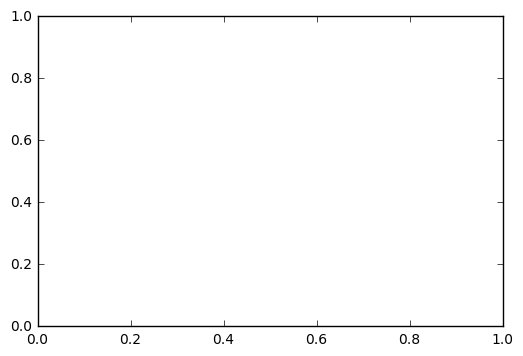

In [46]:
fig, axis =plt.subplots()
N_arr = np.array([128, 256, 512, 1024, 2048])
axis.plot(N_arr[:-2], cpu_time_loglike_SSP, ls='-', color='k', label='CPU, SSP')
axis.plot(N_arr, gpu_time_loglike_SSP, ls='-', color='b', label='CUDA C, SSP')
axis.plot(N_arr[:-2], cpu_time_loglike_full, ls='--', color='k', label='CPU, Full')
axis.plot(N_arr, gpu_time_loglike_full, ls='--', color='b', label='CUDA C, Full')
axis.set_xlabel(r'N$_\mathrm{scale}$', fontsize='xx-large'), axis.set_ylabel('Time (s)', fontsize='xx-large')
axis.legend(loc=0), axis.set_yscale('log'), axis.set_xscale('log')
axis.set_title('Likelihood Call Time', fontsize='x-large')
plt.savefig('results/likelihood_call_time.pdf')

In [49]:
def time_psf(driv, gal_model, N_scale_arr, multi_psf=True, iters=5):
    f = driv.filters[0]
    times = np.zeros_like(N_scale_arr, dtype=float)
    for i in np.arange(len(N_scale_arr)):
        N_scale = N_scale_arr[i]
#         _, _, images, _ = driv.simulate(gal_model, N_scale, psf=False)
#         im = images[0]
        im = np.random.uniform(low=0, high=1e5, size=(N_scale, N_scale))
        temp = []
        for j in np.arange(iters):
            start = time.time()
            _ = f.psf_convolve(im, multi_psf=multi_psf)
            temp.append(time.time() - start)
        times[i] = np.mean(temp)
    return times

In [53]:
N_scale_arr = np.array([256, 512, 1024, 2048, 4096])
times = time_psf(driver_cpu, gal_model_simple, N_scale_arr)
times_simple = time_psf(driver_cpu, gal_model_simple, N_scale_arr, multi_psf=False)

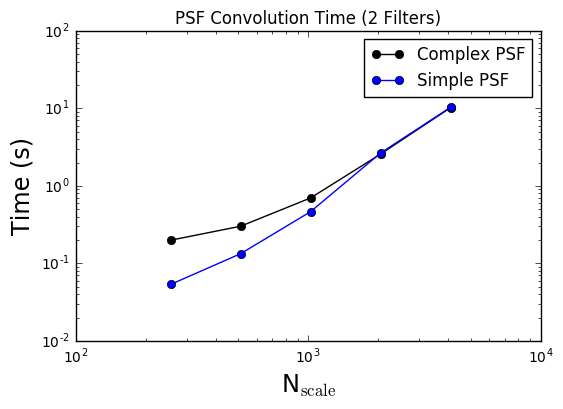

In [55]:
fig, axis = plt.subplots()
axis.plot(N_scale_arr, 2.*times, 'ko-', label='Complex PSF')
axis.plot(N_scale_arr, 2.*times_simple, 'bo-', label='Simple PSF')
axis.set_xlabel(r'N$_\mathrm{scale}$', fontsize='xx-large'), axis.set_ylabel(r'Time (s)', fontsize='xx-large')
plt.legend(loc=0)
axis.set_xscale('log'), axis.set_yscale('log')
axis.set_title('PSF Convolution Time (2 Filters)')
plt.savefig('results/PSF_convolve_time.pdf')

In [21]:
%%time
_=gpu_utils._draw_image_numpy(SFH, fluxes, 256)

CPU times: user 9.44 s, sys: 808 ms, total: 10.2 s
Wall time: 10.2 s


In [22]:
%%time
_=gpu_utils._draw_image_pycuda(SFH, fluxes, 256)

CPU times: user 1.15 s, sys: 704 ms, total: 1.86 s
Wall time: 2.05 s


In [23]:
%%time
_=gpu_utils._draw_image_cudac(SFH, fluxes, 256)

CPU times: user 72 ms, sys: 26 ms, total: 98 ms
Wall time: 224 ms


In [ ]:
import pycuda.curandom

In [36]:
%%time
_, mags_sim, _, _ = driver_gpu.simulate(gal_model_simple, 1024, psf=False)

CPU times: user 402 ms, sys: 84 ms, total: 486 ms
Wall time: 709 ms


In [20]:
%%time
_, mags_dust, _, _ = driver_gpu.simulate(gal_model_dust, im_scale)

CPU times: user 1.16 s, sys: 184 ms, total: 1.35 s
Wall time: 1.47 s


In [82]:
%%time
_, mags_data, _, _ = driver_gpu.simulate(gal_model_simple, im_scale)

CPU times: user 4.18 s, sys: 305 ms, total: 4.48 s
Wall time: 4.6 s


In [7]:
%%time
raw_mags_g, mags_g, raw_images_g, images_g = driver_gpu.simulate(gal_model_simple, 1024)

CPU times: user 2.97 s, sys: 1.98 s, total: 4.95 s
Wall time: 5.3 s


In [48]:
# pcmd_sim = np.array([mags_sim[0]-mags_sim[1], mags_sim[1]])
pcmd_data = np.array([mags_data[0]-mags_data[1], mags_data[1]])
# pcmd_dust = np.array([mags_dust[0]-mags_dust[1], mags_dust[1]])

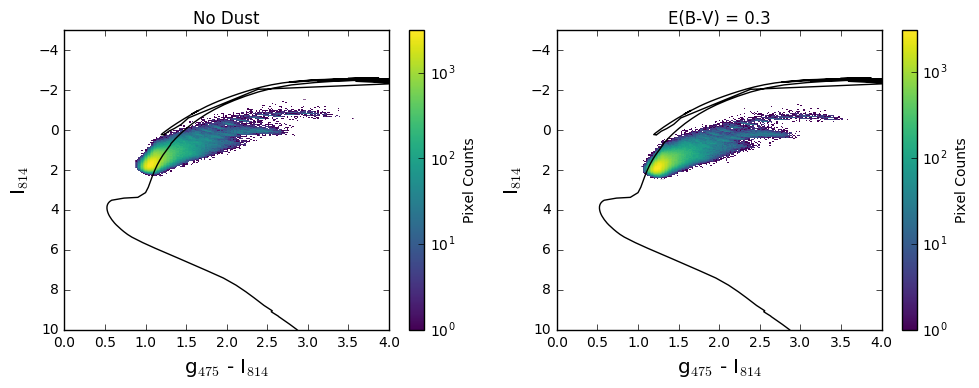

In [236]:
fig, axes = plt.subplots(figsize=(10,4), ncols=2)
plot_pixcmd(pcmd_sim[0], pcmd_sim[1], ax=axes[0], colorbar=True)
plot_pixcmd(pcmd_dust[0], pcmd_dust[1], ax=axes[1])
iso_model.plot_isochrone(gal_model_simple, ax=axes[0])
iso_model.plot_isochrone(gal_model_simple, ax=axes[1])
axes[0].set_ylim([10, -5])
axes[0].set_xlim([0, 4])
axes[1].set_ylim([10, -5])
axes[1].set_xlim([0, 4])
axes[0].set_title('No Dust'), axes[1].set_title('E(B-V) = 0.3')
plt.tight_layout()
# plt.savefig('../../sandbox/2b_PSF.pdf')

In [21]:
pcmd_data = driver_gpu._make_pcmd(mags_sim)
pcmd_dust = driver_gpu._make_pcmd(mags_dust)

In [113]:
reload(driver)
driver_cpu = driver.Driver(iso_model, gpu=False)

GPU acceleration not available


In [23]:
xbins, ybins = np.arange(-1.5, 4.6, 0.05), np.arange(-12, 5.6, 0.05)
bins = [xbins, ybins]

driver_gpu.initialize_data(pcmd_data, bins)

In [24]:
driver_gpu.loglike(pcmd_dust, use_gaussian=True, charlie=False)

-355129.09018144867

In [25]:
driver_gpu.loglike(pcmd_dust, use_gaussian=True, charlie=True)

-354906.74314799561

In [26]:
driver_gpu.initialize_data(pcmd_data, bins)

In [9]:
def lnprior(gal_params):
    log_Npix, age, z, dust = gal_params
    #Flat prior
    #Npix between 0.1 and 1e6
    if (log_Npix < -1) or (log_Npix > 6):
        return -np.inf
    #age between 6 (1 Myr) and 10.3 (50 Gyr)
    elif (age < 6.) or (age > 10.3):
        return -np.inf
    #z between -2 and 0.5
    elif (z < -2.) or (z>0.5):
        return -np.inf
    #E(B-V) between 0 and 2
    elif (dust < -0.5) or (dust > 2.):
        return -np.inf
    else:
        return 1

In [10]:
def lnprob(gal_params, driv, im_scale, **kwargs):
    pri = lnprior(gal_params)
    if np.isinf(pri):
        return -np.inf
    gal_model = gal.Simple_Galaxy(gal_params)
    _, mags, _, _ = driv.simulate(gal_model, im_scale)
    pcmd = np.array([mags[0]-mags[1], mags[1]])
    return pri + driv.loglike(pcmd, **kwargs)

In [27]:
nwalkers = 10
ndim = 4
# Npix0 = (5*np.random.random(size=nwalkers)) #log-uniform from 1e0 -> 1e5
# age0 = 6.+(4.*np.random.random(size=nwalkers)) #uniform from 6 -> 10
# z0 = -1.5 + (2.*np.random.random(size=nwalkers)) #uniform from -1.5 -> 0.5
# dust_0 = np.random.random(size=nwalkers) #uniform from 0 -> 1
# p0 = np.array([Npix0, age0, z0, dust_0]).T

In [28]:
p0_single = np.array([2.1, 10., -0.1, 0.2])

In [29]:
p0 = emcee.utils.sample_ball(p0_single, np.array([.5, 0.1, 0.25, 0.1]),
                             size=nwalkers)

In [30]:
p0

array([[  2.65788809,   9.9509787 ,  -0.44473897,   0.1593951 ],
       [  2.35831675,   9.88118485,  -0.26360956,   0.13124404],
       [  2.12662815,  10.03458054,  -0.0450831 ,   0.256572  ],
       [  1.60030576,   9.95491743,  -0.20052581,   0.07332498],
       [  2.60411377,   9.96278638,  -0.18755041,   0.31408711],
       [  2.09429014,   9.86597811,   0.0684526 ,   0.35543917],
       [  2.45808529,   9.99215514,  -0.15567886,   0.31870128],
       [  2.3058259 ,  10.09414496,  -0.02139286,   0.1291896 ],
       [  2.60033984,  10.01661933,  -0.14780299,   0.30935007],
       [  3.13715033,   9.85811219,  -0.37741214,   0.18540717]])

In [31]:
p0.shape

(10, 4)

In [32]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[driver_gpu, 512]) #test with 256x256 models

In [33]:
%%time
sampler.reset()
pos, prob, state = sampler.run_mcmc(p0, 20)

CPU times: user 3min 46s, sys: 35.2 s, total: 4min 21s
Wall time: 4min 46s


In [37]:
%%time
sampler.reset()
sampler.run_mcmc(pos, 80)

CPU times: user 13min 21s, sys: 2min 31s, total: 15min 52s
Wall time: 17min 30s


In [34]:
sampler.lnprobability

array([[-522593.91748426, -522593.91748426, -522593.91748426,
        -518711.80301518, -518711.80301518, -518711.80301518,
        -480591.77836348, -475628.03713136, -475628.03713136,
        -475628.03713136, -475628.03713136, -475628.03713136,
        -475628.03713136, -475628.03713136, -475628.03713136,
        -475628.03713136, -475628.03713136, -475628.03713136,
        -428112.33885728, -425370.33961375],
       [-498283.02879135, -473634.72360562, -437850.39134557,
        -437850.39134557, -437850.39134557, -436587.90511794,
        -372465.67765645, -372465.67765645, -372070.61319091,
        -372070.61319091, -372070.61319091, -372070.61319091,
        -372070.61319091, -372070.61319091, -372070.61319091,
        -372070.61319091, -372070.61319091, -353115.75176593,
        -291896.95698825, -151241.14465791],
       [-491441.29811646, -458383.78081027, -452747.27782479,
        -452747.27782479, -452747.27782479, -452747.27782479,
        -452747.27782479, -452747.27782479

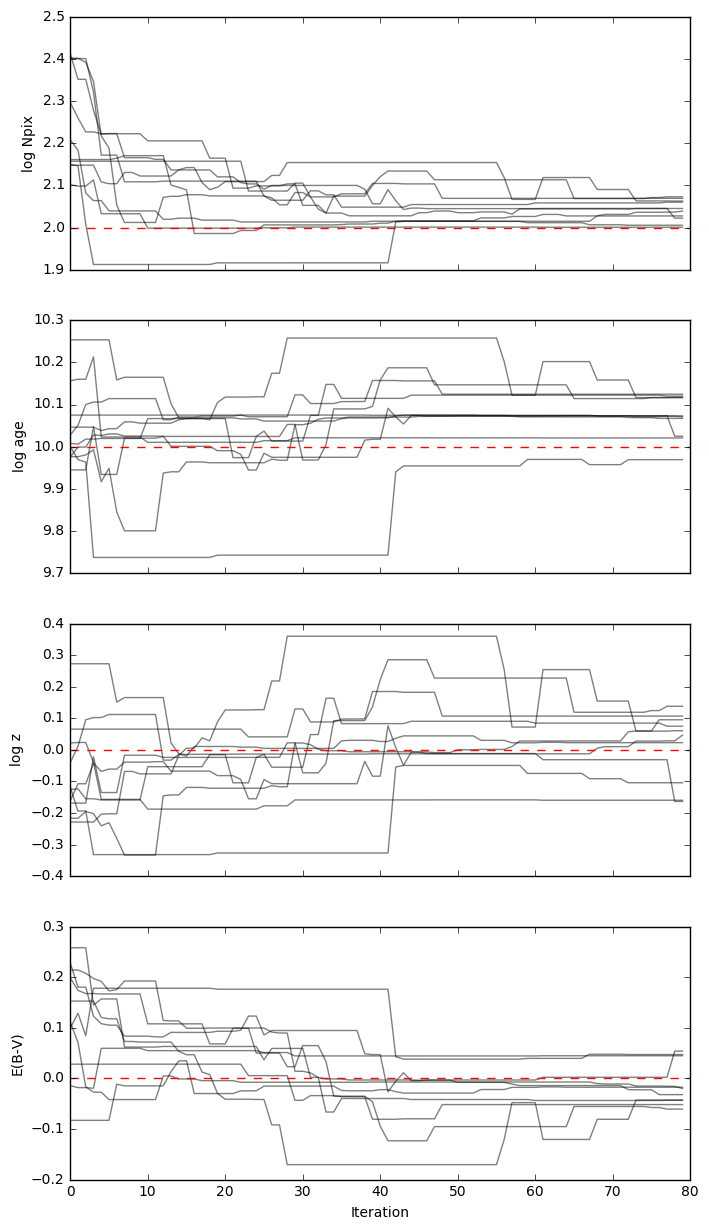

In [38]:
fig, axes = plt.subplots(figsize=(8,15), nrows=4, sharex=True)
for i in np.arange(4):
    vals = sampler.chain[:,:,i]
    for arr in vals:
        axes[i].plot(arr, ls='-', alpha=0.5, c='k')
axes[3].set_xlabel('Iteration')
axes[0].set_ylabel('log Npix')
axes[0].axhline(y=2, ls='--', color='r')
axes[1].set_ylabel('log age')
axes[1].axhline(y=10., ls='--', color='r')
axes[2].set_ylabel('log z')
axes[2].axhline(y=0., ls='--', color='r')
axes[3].set_ylabel('E(B-V)')
axes[3].axhline(y=0., ls='--', color='r')

In [29]:
%%time
_, mags_sim_gpu, _, _ = driver_gpu.simulate(gal_model_simple, 256, psf=True)
_, mags_dust_gpu, _, _ = driver_gpu.simulate(gal_model_dust, 256, psf=True)

CPU times: user 396 ms, sys: 75 ms, total: 471 ms
Wall time: 734 ms


In [30]:
%%time
_, mags_sim_cpu, _, _ = driver_cpu.simulate(gal_model_simple, 256, psf=True)
_, mags_dust_cpu, _, _ = driver_cpu.simulate(gal_model_dust, 256, psf=True)

CPU times: user 2.16 s, sys: 214 ms, total: 2.37 s
Wall time: 2.37 s


In [31]:
pcmd_sim_gpu = utils.make_pcmd(mags_sim_gpu)
pcmd_dust_gpu = utils.make_pcmd(mags_dust_gpu)
pcmd_sim_cpu = utils.make_pcmd(mags_sim_cpu)
pcmd_dust_cpu = utils.make_pcmd(mags_dust_cpu)


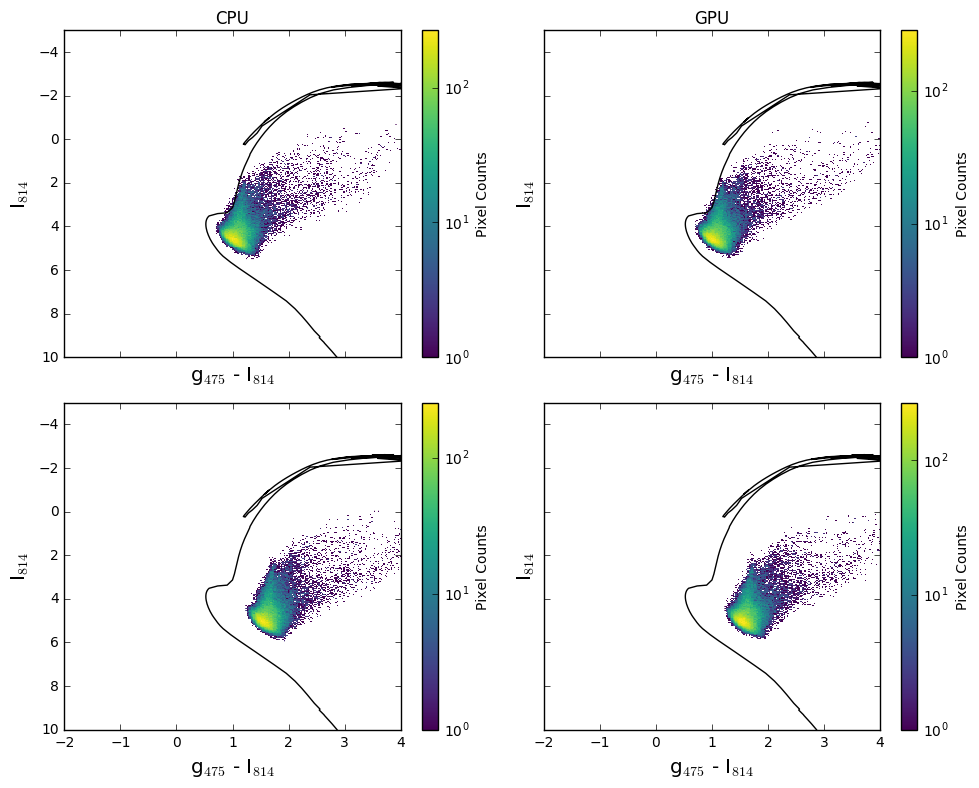

In [33]:
fig, axes = plt.subplots(figsize=(10,8), ncols=2, nrows=2, sharex=True, sharey=True)
axes = axes.flatten()
plot_pixcmd(pcmd_sim_cpu, ax=axes[0], colorbar=True)
plot_pixcmd(pcmd_sim_gpu, ax=axes[1], colorbar=True)
plot_pixcmd(pcmd_dust_cpu, ax=axes[2], colorbar=True)
plot_pixcmd(pcmd_dust_gpu, ax=axes[3], colorbar=True)
iso_model.plot_isochrone(gal_model_simple, ax=axes[0])
iso_model.plot_isochrone(gal_model_simple, ax=axes[1])
iso_model.plot_isochrone(gal_model_simple, ax=axes[2])
iso_model.plot_isochrone(gal_model_simple, ax=axes[3])
axes[0].set_ylim([10, -5])
axes[0].set_xlim([-2, 4])
axes[0].set_title('CPU'), axes[1].set_title('GPU')
plt.tight_layout()
# plt.savefig('../../sandbox/2b_PSF.pdf')

In [9]:
%%time
raw_mags_c, mags_c, raw_images_c, images_c = driver_cpu.simulate(gal_model_complex, 512)

CPU times: user 19.4 s, sys: 3.49 s, total: 22.9 s
Wall time: 28 s


In [10]:
%%time
raw_mags_g, mags_g, raw_images_g, images_g = driver_gpu.simulate(gal_model_complex, 512)

CPU times: user 3.67 s, sys: 845 ms, total: 4.52 s
Wall time: 5.98 s


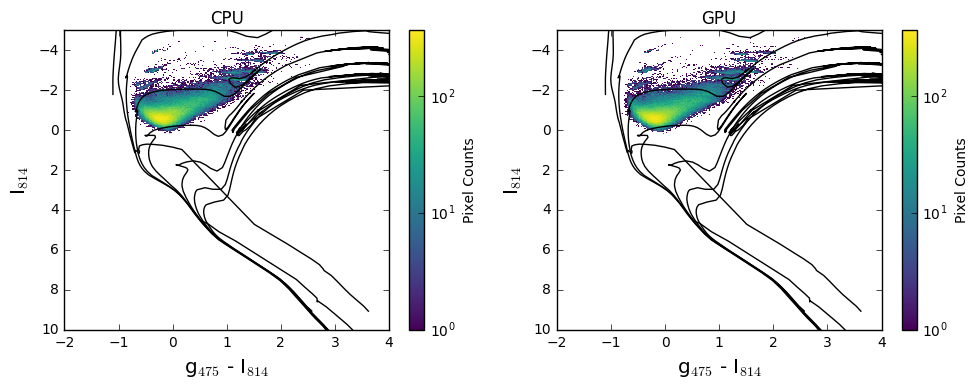

In [11]:
fig, axes = plt.subplots(figsize=(10,4), ncols=2)
plot_pixcmd(mags_c[0]-mags_c[1], mags_c[1], ax=axes[0], colorbar=True)
plot_pixcmd(mags_g[0]-mags_g[1], mags_g[1], ax=axes[1])
iso_model.plot_isochrone(gal_model_complex, ax=axes[0])
iso_model.plot_isochrone(gal_model_complex, ax=axes[1])
axes[0].set_ylim([10, -5])
axes[0].set_xlim([-2, 4])
axes[1].set_ylim([10, -5])
axes[1].set_xlim([-2, 4])
axes[0].set_title('CPU'), axes[1].set_title('GPU')
plt.tight_layout()
# plt.savefig('../../sandbox/2b_PSF.pdf')

In [21]:
scale_arr = [128, 256, 512, 1024, 2048, 4096]

t_cpu_simple = np.zeros_like(scale_arr, dtype=float)
t_gpu_simple = np.zeros_like(scale_arr, dtype=float)
t_cpu_complex = np.zeros_like(scale_arr, dtype=float)
t_gpu_complex = np.zeros_like(scale_arr, dtype=float)

In [ ]:
for i, scale in enumerate(scale_arr):
    print('Evaluating %d pixels'%(scale))
    if (scale < 2048):
        print('---CPU Simple')
        start = time.time()
        _ = driver_cpu.simulate(gal_model_simple, scale)
        t_cpu_simple[i] = time.time() - start
    if (scale < 1024):
        print('---CPU Complex')
        start = time.time()
        _ = driver_cpu.simulate(gal_model_complex, scale)
        t_cpu_complex[i] = time.time() - start
    print('---GPU Simple')
    start = time.time()
    _ = driver_gpu.simulate(gal_model_simple, scale)
    t_gpu_simple[i] = time.time() - start
    print('---GPU Complex')
    start = time.time()
    _ = driver_gpu.simulate(gal_model_complex, scale)
    t_gpu_complex[i] = time.time() - start

Evaluating 128 pixels
---CPU Simple
---CPU Complex
---GPU Simple
---GPU Complex
Evaluating 256 pixels
---CPU Simple
---CPU Complex
---GPU Simple
---GPU Complex
Evaluating 512 pixels
---CPU Simple
---CPU Complex
---GPU Simple
---GPU Complex
Evaluating 1024 pixels
---CPU Simple
---GPU Simple
---GPU Complex
Evaluating 2048 pixels
---GPU Simple
---GPU Complex
Evaluating 4096 pixels
---GPU Simple
---GPU Complex


In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(scale_arr[:-1], t_cpu_simple[:-1], 'ro', ls='-', label='CPU, SSP')
ax.plot(scale_arr[:-2], t_cpu_complex[:-2], 'r*', ls='--', label='CPU, Complex')
ax.plot(scale_arr, t_gpu_simple, 'bo', ls='-', label='GPU, SSP')
ax.plot(scale_arr, t_gpu_complex, 'b*', ls='--', label='GPU, Complex')
ax.legend(loc=4)
ax.set_xlabel('Image Scale (NxN pixels)', fontsize='xx-large')
# ax.set_xscale('log')
ax.set_xticks(scale_arr)
ax.set_ylabel('Time Elapsed (s)', fontsize='xx-large')
ax.set_yscale('log')

In [11]:
im_scale = 256

In [12]:
gal_model_simple = gal.Galaxy_SSP(np.array([0., -2., 2., 10.]))
gal_model_dust = gal.Galaxy_SSP(np.array([0., -0.5, 1., 10.]))
gal_model_full = gal.Galaxy_Model(np.array([0., -2., 1., 1., 1., 1., 1., 1., 1.]))

In [13]:
xbins, ybins = np.arange(-1.5, 4.6, 0.1), np.arange(-12, 15.6, 0.1)
bins = np.array([xbins, ybins])

In [14]:
%%time
_, mags_single, _, _ = driver_cpu.simulate(gal_model_simple, im_scale, psf=True)

CPU times: user 952 ms, sys: 135 ms, total: 1.09 s
Wall time: 1.15 s


In [15]:
pcmd_ssp = utils.make_pcmd(mags_single)

In [16]:
driver_cpu.initialize_data(pcmd_ssp, bins)

In [17]:
driver_cpu.loglike(pcmd_ssp)

-0.0

In [18]:
im_scale = 128

(0, 3)

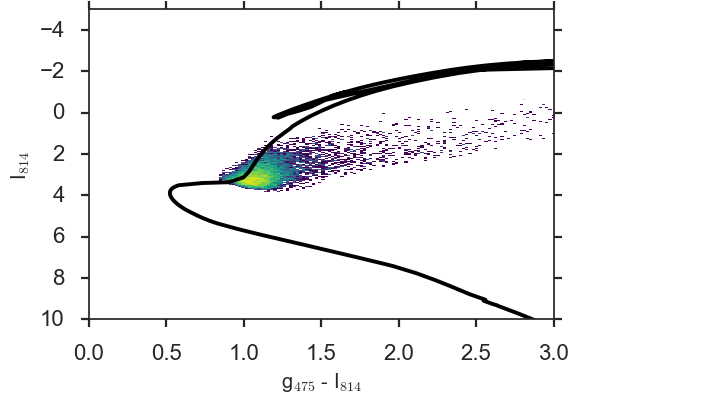

In [114]:
fig, axis =plt.subplots()
_, mags_single, _, _ = driver_cpu.simulate(gal_model_simple, im_scale, psf=True)
plot_pixcmd(mags_single, ax=axis, colorbar=False)
iso_model.plot_isochrone(gal_model_simple, ax=axis)
axis.set_ylim([10, -5])
axis.set_xlim([0, 3])

0: -9.62e+02
1: -4.84e+02
2: -5.36e+02
3: -6.12e+02
4: -5.51e+02
5: -4.58e+02
6: -6.11e+02
7: -6.49e+02
8: -4.44e+02


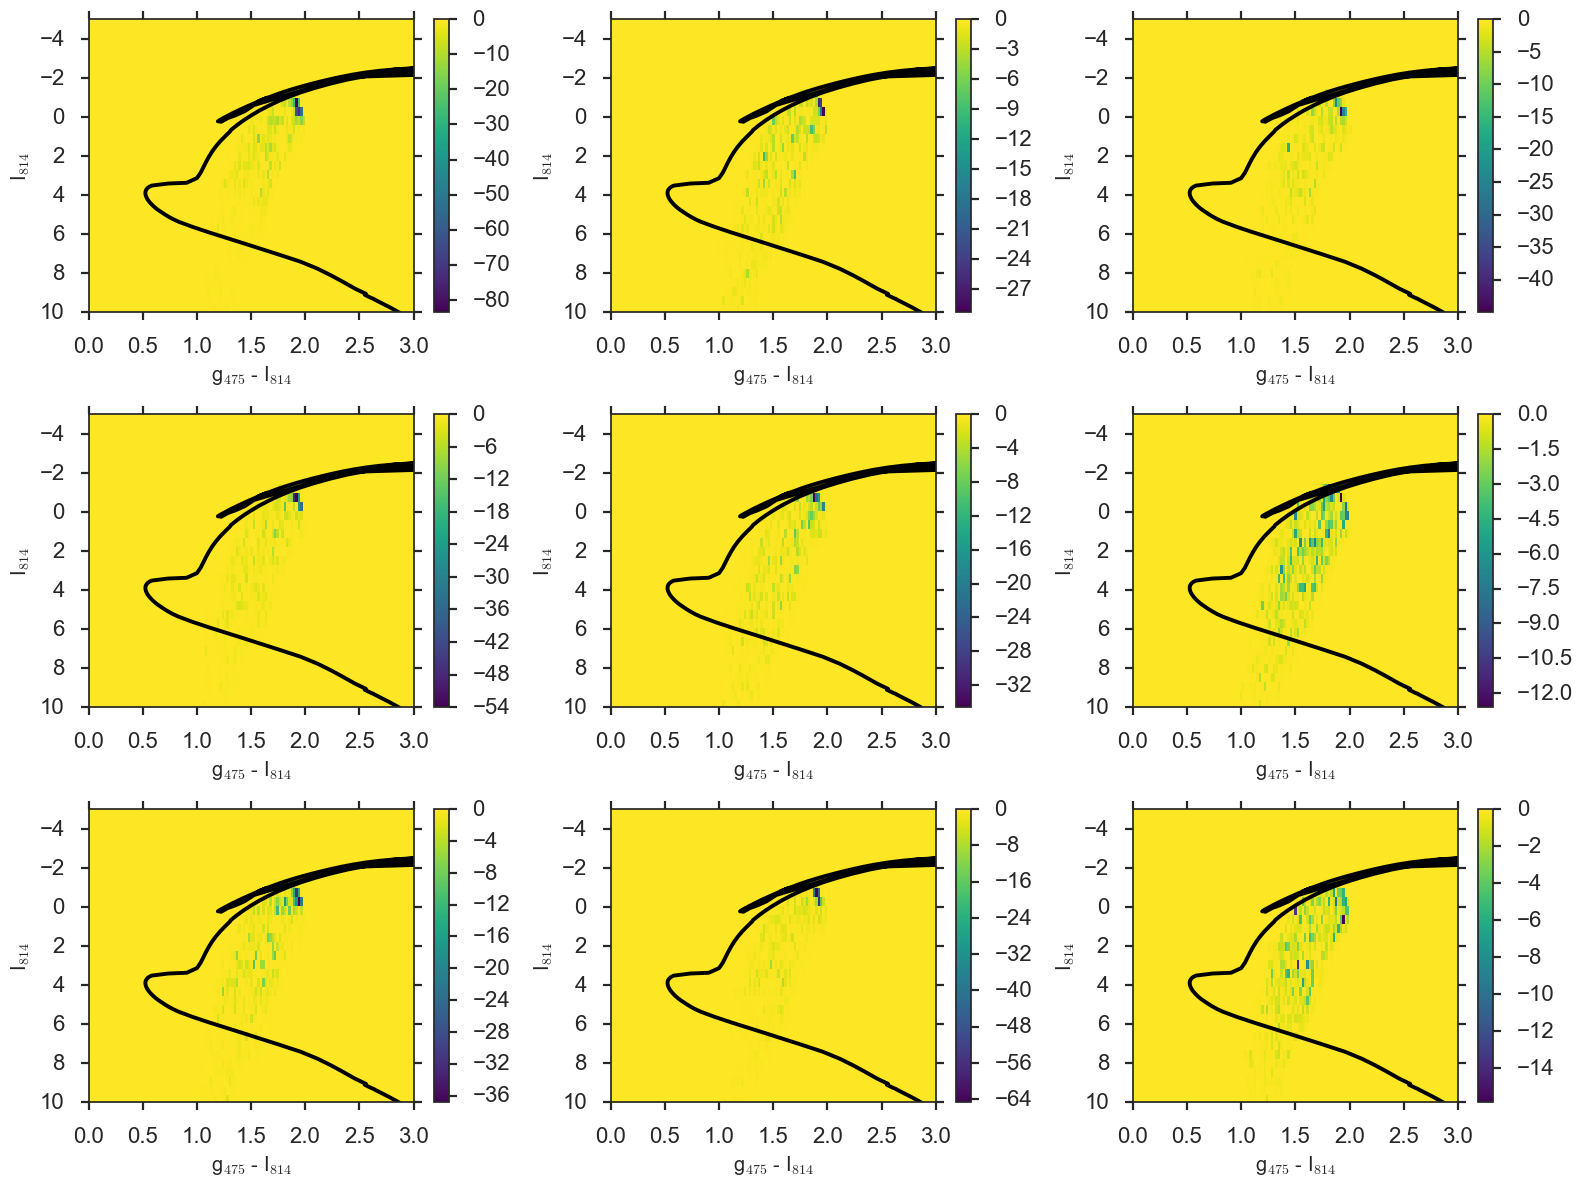

In [31]:
like_hists = []
counts = []
loglikes = []
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,12))
axes = axes.flatten()
for i in range(len(axes)):
    axis = axes[i]
    _, mags, _, _ = driver_cpu.simulate(gal_model_simple, im_scale, psf=True)
    pcmd = utils.make_pcmd(mags)
    counts_model, hess_model, err_model = utils.make_hess(pcmd, driver_cpu.hess_bins)
    combined_var = (driver_cpu.err_data**2 + err_model**2)
    hess_diff = (driver_cpu.hess_data - hess_model)
    log_like = -(hess_diff**2 / combined_var)
    plt.subplot(axis)
    plt.imshow(log_like, extent=(-1.5, 4.55, 15.6, -12), aspect='auto', cmap='viridis', interpolation='None')
    plt.colorbar()
    iso_model.plot_isochrone(gal_model_simple, ax=axis)
    axis.set_xlim([0, 3]), axis.set_ylim([10, -5])
    print('%d: %.2e'%(i, np.sum(log_like)))
    loglikes.append(np.sum(log_like))
    like_hists.append(log_like)
    counts.append(counts_model)
plt.tight_layout()

In [32]:
counts[0][like_hists[0] == like_hists[0].min()]

array([ 37.])

(array([  1.60900000e+04,   1.64000000e+02,   8.80000000e+01,
          4.80000000e+01,   2.90000000e+01,   2.70000000e+01,
          1.60000000e+01,   1.40000000e+01,   1.60000000e+01,
          8.00000000e+00]),
 array([ 0.        ,  0.29258276,  0.58516551,  0.87774827,  1.17033103,
         1.46291379,  1.75549654,  2.0480793 ,  2.34066206,  2.63324482,
         2.92582757]),
 <a list of 10 Patch objects>)

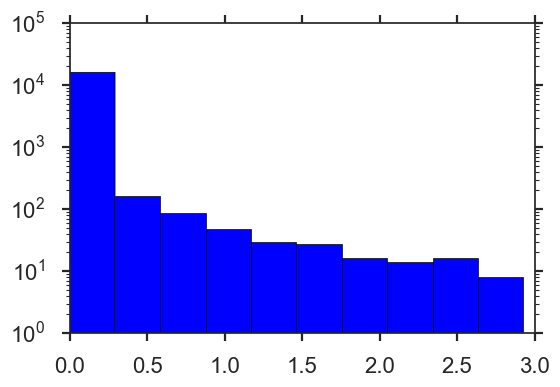

In [28]:
plt.hist(np.log10(counts[0].flatten()+ 1.),log=True)

In [75]:
loglikes_empty = []
for i in range(10):
    _, mags, _, _ = driver_cpu.simulate(gal_model_empty, im_scale, psf=True)
    pcmd = utils.make_pcmd(mags)
    loglikes_empty.append(driver_cpu.loglike(pcmd))
    print('%d: %.2e'%(i, loglikes_empty[-1]))

0: -2.10e+05
1: -2.08e+05
2: -2.08e+05
3: -2.09e+05
4: -2.03e+05
5: -2.08e+05
6: -2.09e+05
7: -2.08e+05
8: -2.04e+05
9: -2.04e+05


In [84]:
gal_model_empty = gal.Galaxy_SSP(np.array([-2., 0., -3., 10.2]))

In [85]:
%%time
_, mags_empty, _, _ = driver_cpu.simulate(gal_model_empty, im_scale, psf=True)

CPU times: user 809 ms, sys: 128 ms, total: 937 ms
Wall time: 1.39 s


(0, 4)

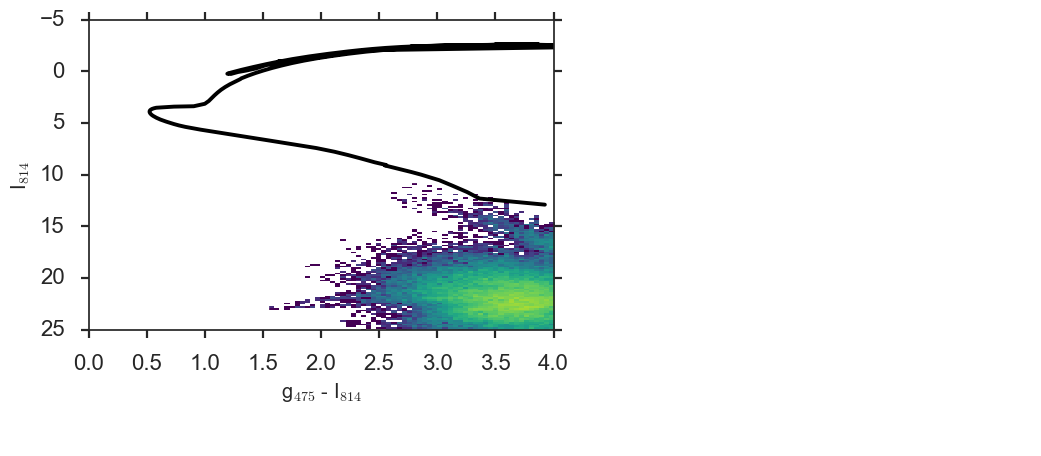

In [86]:
fig, axis =plt.subplots()
_, mags_single, _, _ = driver_cpu.simulate(gal_model_empty, im_scale, psf=True)
plot_pixcmd(mags_single, ax=axis, colorbar=False)
iso_model.plot_isochrone(gal_model_simple, ax=axis)
axis.set_ylim([25, -5])
axis.set_xlim([0, 4])

0
1
2
3
4
5
6
7
8


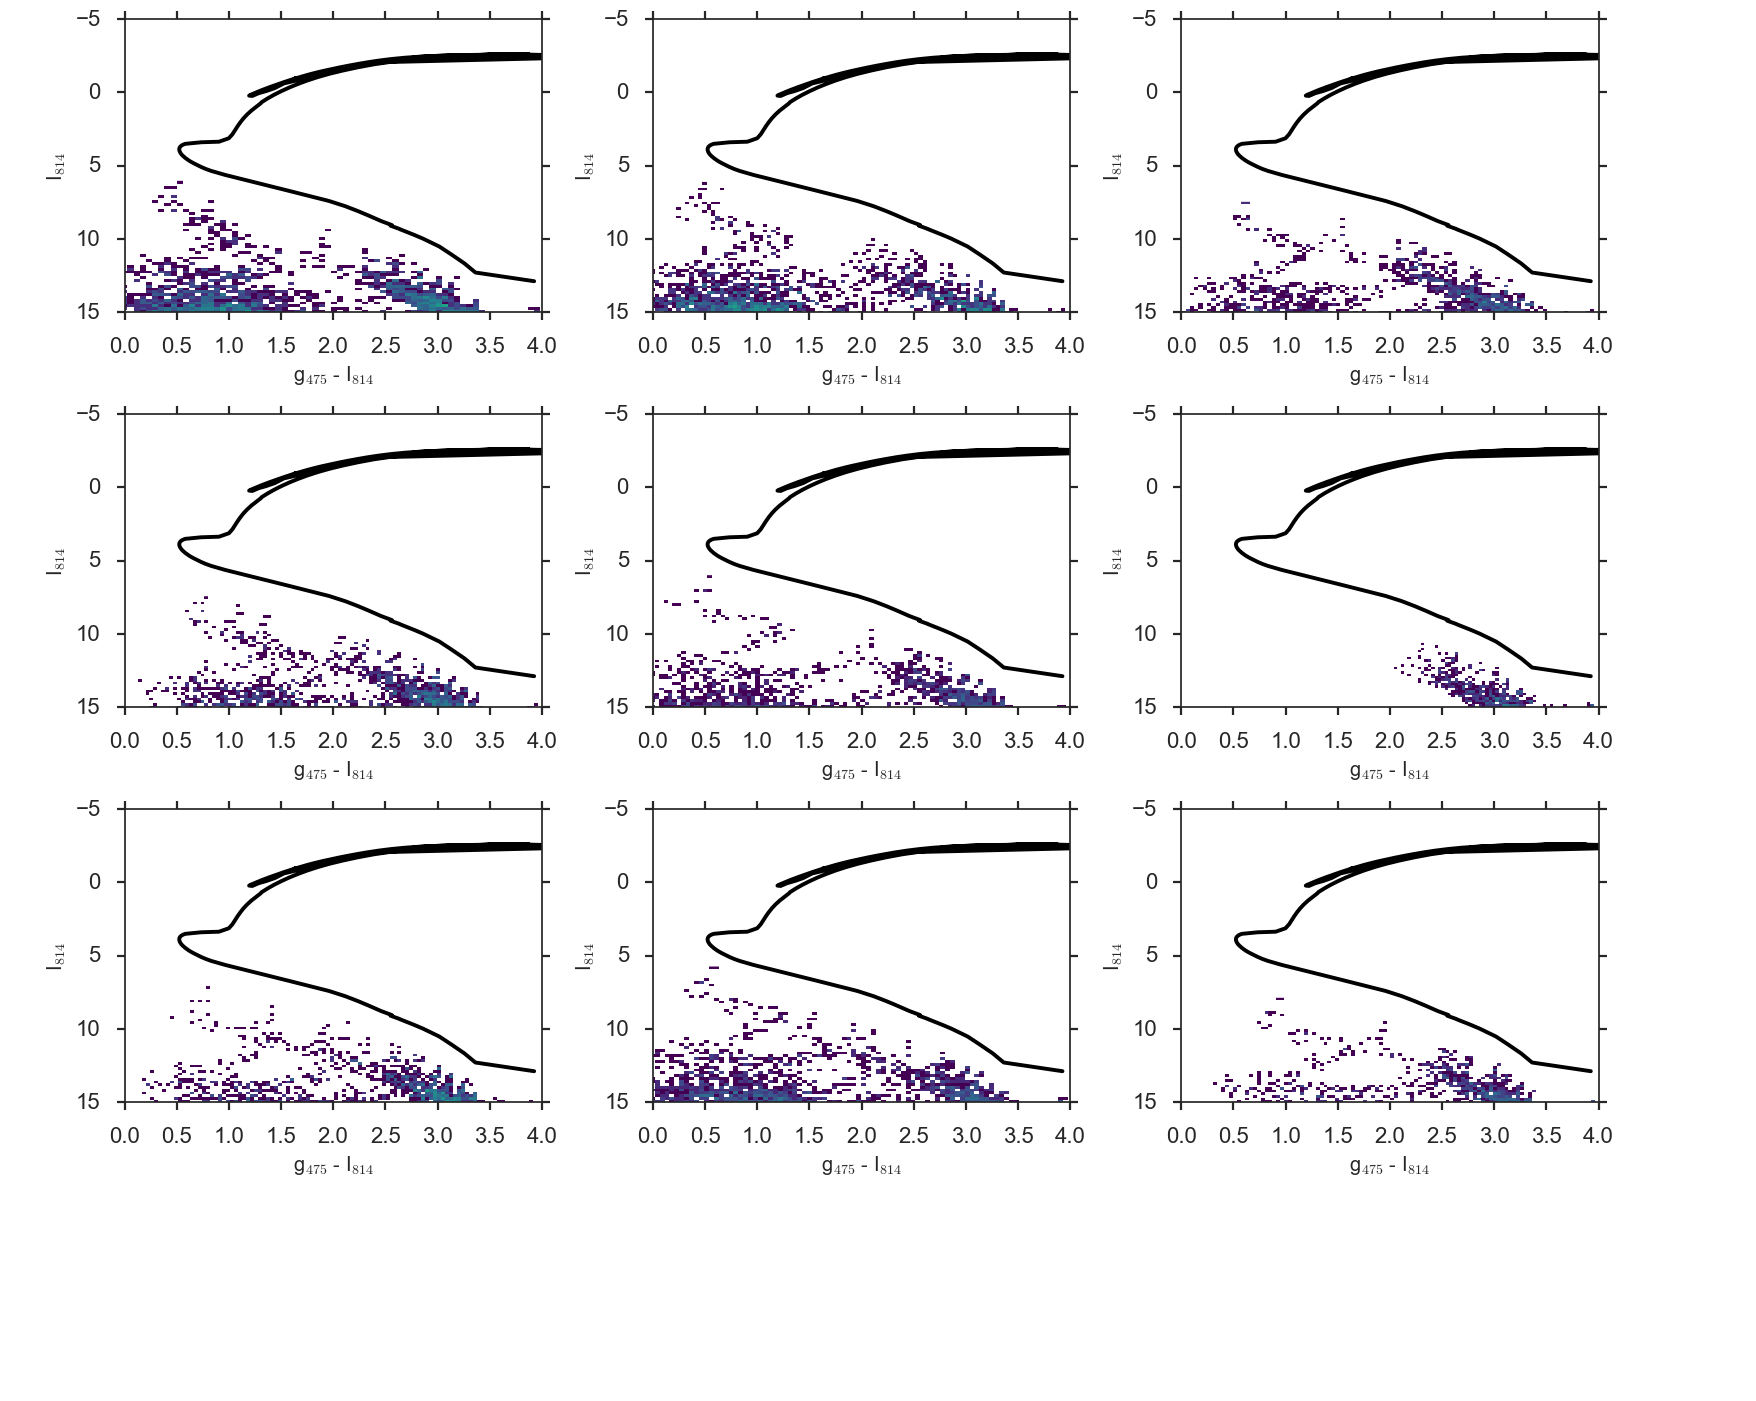

In [81]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,12))
axes = axes.flatten()
for i in range(len(axes)):
    print(i)
    axis = axes[i]
    _, mags_single, _, _ = driver_cpu.simulate(gal_model_empty, im_scale, psf=True)
    plot_pixcmd(mags_single, ax=axis, colorbar=False)
    iso_model.plot_isochrone(gal_model_simple, ax=axis)
    axis.set_ylim([15, -5])
    axis.set_xlim([0, 4])
plt.tight_layout()

In [32]:
mags_empty

array([[ 15.10365791,  15.24430873,  15.25730594, ...,  14.24658234,
         14.38802279,  14.615087  ],
       [ 13.3760692 ,  13.76466888,  13.45358788, ...,  12.38695961,
         12.52904746,  12.85806385]])

(0, 4)

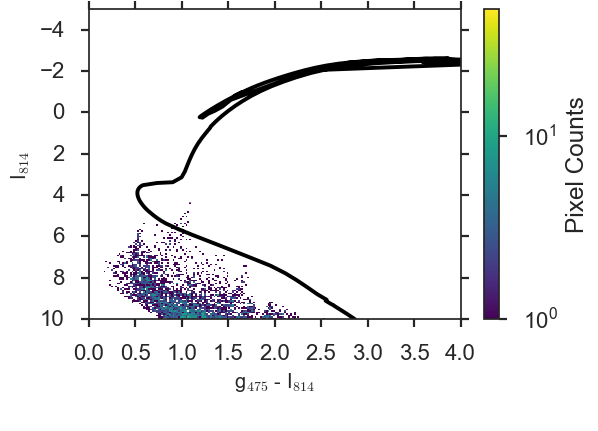

In [33]:
fig, axis = plt.subplots()
plot_pixcmd(mags_empty, ax=axis)
iso_model.plot_isochrone(gal_model_empty, ax=axis)
axis.set_ylim([10, -5])
axis.set_xlim([0, 4])


In [3]:
import pandas as pd, numpy as np

In [23]:
a = {}
a["128,1"] = np.random.randint(0, 10, 100)
a["128,2"] = np.random.randint(0, 10, 100)

In [24]:
b = pd.DataFrame(a)

In [25]:
b.head()

,"128,1","128,2"
0,5,6
1,7,0
2,9,5
3,3,3
4,3,9


In [26]:
b.to_csv('/Users/bcook/sandbox/test.csv', index=False)

In [27]:
pd.read_csv('/Users/bcook/sandbox/test.csv')

,"128,1","128,2"
0,5,6
1,7,0
2,9,5
3,3,3
4,3,9
5,1,6
6,5,3
7,7,2
8,8,2
9,7,4
